# Exploratory Data Analysis (EDA) for Model Training Dataset

## 1. Business Objectives and KPIs

### Business Objective

To build a supervised machine learning model that estimates the probability of porphyry copper deposit occurrence at any given geographic coordinate in Australia. 

Unlike binary classification (e.g., mineralized vs. non-mineralized), this task focuses on distinguishing porphyry copper deposits specifically from other types of deposits or non-deposit areas. The goal is to produce continuous-valued probabilities rather than discrete predictions, allowing more flexible ranking and risk assessment.

The model will serve as a decision support tool for geologists, guiding exploration strategy by prioritizing high-potential porphyry targets across large areas.

---

### Key Performance Indicators (KPIs)

| KPI | Description |
|-----|-------------|
| **Probability output** | For each (lon, lat), output a float between 0 and 1 indicating porphyry Cu potential |
| **Confidence interval / uncertainty score** | Quantify model confidence in the prediction (e.g., via ensemble std, dropout variance, or calibrated uncertainty) |
| **AUC-ROC** | How well the model distinguishes porphyry Cu from others |
| **Precision @ top K%** | Of all locations ranked by predicted probability, what percent of true porphyry Cu sites fall in top K |
| **Log-loss (cross-entropy)** | Penalizes overly confident wrong predictions (suitable for probabilistic output) |
| **Spatial recall of known porphyry Cu** | % of known porphyry deposits above a defined probability threshold |
| **Exploration efficiency index** | Ratio of porphyry Cu hits vs total predicted “high probability” points |


## 2. Dataset Overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined sample-feature dataset
df = pd.read_csv("../../data/processed/model_input_samples.csv")  

### 2.1. Sample Features

| Feature | Description |
|--------|-------------|
| `LONGITUDE`, `LATITUDE` | Geographic coordinates of the sample point (WGS84) |
| `SOURCE` | Origin of the sample: `positive` (porphyry copper), `other_deposit` (non-porphyry deposit), `blank_area` (non-mineralized area) |
| `gravity_iso_residual`, `gravity_cscba`, `gravity_cscba_1vd` | Gravity anomaly values from different processing techniques (e.g., isostatic residual, CSCBA, first vertical derivative) |
| `mag_uc_*` | Upward continued magnetic anomalies at different depths (1–2 km, 2–4 km, 4-8 km, 8-12 km and 12-16km.) |
| `radio_K_pct`, `radio_Th_ppm`, `radio_U_ppm` | Radiometric concentrations of potassium (K), thorium (Th), and uranium (U) |
| `radio_Th_K_ratio`, `radio_U_K_ratio`, `radio_U_Th_ratio` | Derived ratios from radiometric bands |
| `LABEL` | Binary target label: `1` = porphyry copper sample (positive), `0` = non-porphyry (negative) |


- The dataset integrates multi-modal geoscience inputs from **gravity**, **magnetic**, and **radiometric** imagery.
- It enables supervised learning by mapping geophysical/geochemical signals to a known deposit type (`LABEL`).
- Class imbalance exists — `positive` samples (label = 1) are significantly fewer than negative cases.

This structured dataset serves as the foundation for both EDA and subsequent model training for porphyry copper prospectivity prediction.

In [2]:
df.head()

,LONGITUDE,LATITUDE,SOURCE,gravity_iso_residual,gravity_cscba,gravity_cscba_1vd,mag_uc_1_2km,mag_uc_2_4km,mag_uc_4_8km,mag_uc_8_12km,mag_uc_12_16km,radio_K_pct,radio_Th_ppm,radio_U_ppm,radio_Th_K_ratio,radio_U_K_ratio,radio_U_Th_ratio,LABEL
0,134.324653,-27.294063,blank_area,-204.018005,-426.38882,-309.04285,-19.665098,-33.036575,-46.971394,-30.871347,-21.795435,0.759041,9.374757,1.196567,12.357069,1.577670,0.127658,0
1,148.050504,-32.937903,positive,93.298981,-186.38301,-2674.96260,-44.330212,23.895699,107.432144,82.715973,57.587337,1.154886,8.526972,1.396929,7.434864,1.215049,0.163990,1
2,119.027100,-22.975700,other_deposit,-200.687836,-739.63226,-1203.50880,-442.748383,-354.920288,-211.401382,-84.787079,-53.003239,0.126347,3.217272,0.572410,16.086359,2.862052,0.178862,0
3,121.464232,-23.649192,blank_area,-163.918274,-592.99493,-536.70370,18.632324,31.867907,50.295372,35.592964,25.073792,0.184210,3.271043,0.369300,16.355215,1.846498,0.113002,0
4,142.469900,-35.168600,other_deposit,-81.172989,-139.28423,-507.28357,-0.266748,-0.374094,-0.820666,-0.999457,-1.124462,0.413259,4.779623,0.953914,11.560739,2.311097,0.200272,0


### 2.2. Statistical Summary of Training Dataset

This section presents a statistical overview of the training dataset used for predicting porphyry copper prospectivity in Australia. The dataset includes 2,850 spatial samples labeled as either porphyry copper (`LABEL = 1`) or non-porphyry (`LABEL = 0`), with features derived from gravity, magnetic, and radiometric GeoTIFF layers.


- **Total Samples**: 2,850
- **Label Distribution**: 33.3% positive (porphyry), 66.7% negative
- **Sample Sources (`SOURCE`)**:
  - `blank_area`: 950 samples (most common)
  - `positive`: samples derived from known porphyry copper locations
  - `other_deposit`: other known deposit types (non-porphyry)

**Geospatial Coverage**

| Metric      | Longitude         | Latitude          |
|-------------|-------------------|-------------------|
| Min         | 113.79            | -43.27            |
| Max         | 153.52            | -12.46            |
| Mean        | 136.35            | -27.15            |

Samples span a wide geographic range across Australia’s landmass.

**Geophysical & Radiometric Feature Distribution (Selected)**

| Feature                     | Mean    | Std Dev | Min      | 25%       | 50%       | 75%       | Max       |
|-----------------------------|---------|---------|----------|-----------|-----------|-----------|-----------|
| `gravity_iso_residual`      | 36.12   | 259.03  | -1209.63 | -112.53   | 81.54     | 226.34    | 674.23    |
| `gravity_cscba_1vd`         | -321.98 | 1821.21 | -8678.19 | -1231.38  | -304.97   | 600.97    | 14102.15  |
| `mag_uc_1_2km`              | 13.70   | 144.92  | -802.57  | -12.30    | -1.70     | 14.56     | 4238.59   |
| `radio_K_pct`               | 0.86    | 0.69    | -0.21    | 0.36      | 0.70      | 1.17      | 4.44      |
| `radio_Th_ppm`              | 9.86    | 8.81    | -2.05    | 5.55      | 8.32      | 11.46     | 246.45    |
| `radio_U_ppm`               | 1.26    | 0.93    | -0.61    | 0.80      | 1.13      | 1.46      | 23.48     |
| `radio_Th_K_ratio`          | 18.28   | 30.23   | 0.00     | 7.19      | 10.95     | 17.75     | 674.86    |
| `radio_U_Th_ratio`          | 0.16    | 0.16    | 0.00     | 0.11      | 0.14      | 0.17      | 4.70      |


In [3]:
# Summary stats
df.describe(include='all')

,LONGITUDE,LATITUDE,SOURCE,gravity_iso_residual,gravity_cscba,gravity_cscba_1vd,mag_uc_1_2km,mag_uc_2_4km,mag_uc_4_8km,mag_uc_8_12km,mag_uc_12_16km,radio_K_pct,radio_Th_ppm,radio_U_ppm,radio_Th_K_ratio,radio_U_K_ratio,radio_U_Th_ratio,LABEL
count,2850.000000,2850.000000,2850,2841.000000,2850.000000,2850.000000,2849.000000,2849.000000,2849.000000,2849.000000,2849.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2759.000000,2850.000000
unique,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,blank_area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,136.352788,-27.152104,NaN,36.116352,-207.962304,-321.982351,13.702118,14.950592,16.303091,9.551727,6.427293,0.860281,9.862972,1.257511,18.279163,2.249612,0.158155,0.333333
std,12.013221,5.961747,NaN,259.031133,301.636777,1821.205239,144.923224,111.144125,86.081916,40.621142,25.368605,0.685313,8.805282,0.927654,30.231291,2.620450,0.159676,0.471487
min,113.786700,-43.273700,NaN,-1209.628296,-1441.380500,-8678.185000,-802.566895,-589.896790,-447.754761,-230.256119,-144.999573,-0.213820,-2.052050,-0.609241,0.000000,0.000000,0.000000,0.000000
25%,125.124051,-32.914407,NaN,-112.528572,-363.520185,-1231.378175,-12.302689,-13.877985,-16.140339,-10.174973,-7.261545,0.363949,5.548763,0.796258,7.192809,0.987754,0.106679,0.000000
50%,138.921400,-26.695890,NaN,81.544319,-165.308585,-304.966140,-1.702872,-0.907161,0.105269,0.089638,0.446120,0.704410,8.323589,1.131003,10.952823,1.561259,0.135470,0.000000
75%,147.431336,-22.198594,NaN,226.338654,-3.116390,600.973050,14.560830,23.895699,33.708477,22.097511,15.185971,1.168961,11.463590,1.462536,17.748465,2.456065,0.170442,1.000000


<Axes: title={'center': 'Class Balance'}, xlabel='LABEL'>

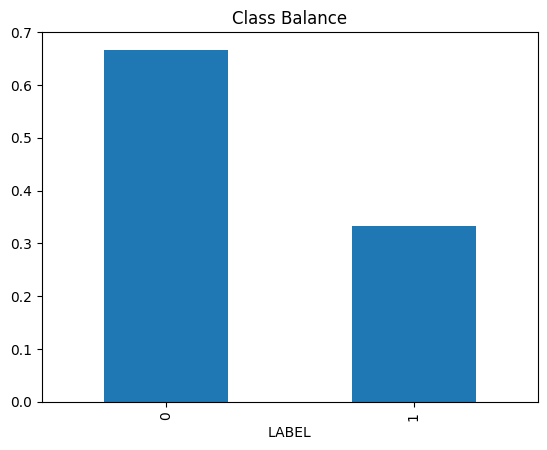

In [5]:
# Class distribution
df['LABEL'].value_counts(normalize=True).plot(kind='bar', title='Class Balance')

### 2.3. Feature Distribution Analysis

The histograms below illustrate the distribution of key geophysical and radiometric features extracted from raster GeoTIFF data across 2,850 training samples.

- **Gravity and Magnetics**:  
  Most gravity features (`gravity_*`) and magnetic anomalies (`mag_uc_*`) show near-normal or slightly skewed distributions. Notably, the `gravity_cscba_1vd` feature shows a wide range, with values exceeding ±8000, indicating potential outliers or high spatial variance.  
  Magnetic features exhibit long tails and extreme values (e.g., `mag_uc_1_2km` has a max > 4000), suggesting the need for normalization or robust scaling.

- **Radiometric Features**:
  Features such as `radio_K_pct`, `radio_Th_ppm`, and `radio_U_ppm` are **strongly right-skewed**, as is common for geochemical concentration data.  
  The derived ratios (e.g., `radio_Th_K_ratio`, `radio_U_Th_ratio`) also show heavy tails, with a few extreme values dominating the range. These features may require log transformation or outlier treatment.

- **Modeling Insight**:  
  Due to the highly varied scales and skewness across features, applying **feature scaling** (standardization or min-max scaling) and **potential outlier handling** (e.g., clipping or log1p transformation) is strongly recommended before training machine learning models.

## Next Steps

- Normalize or transform features with extreme skewness.
- Consider using `SOURCE` as a grouping variable for stratified evaluation or analysis of false positives/negatives.
- Explore correlation between source types and specific feature patterns to guide domain-informed feature engineering.


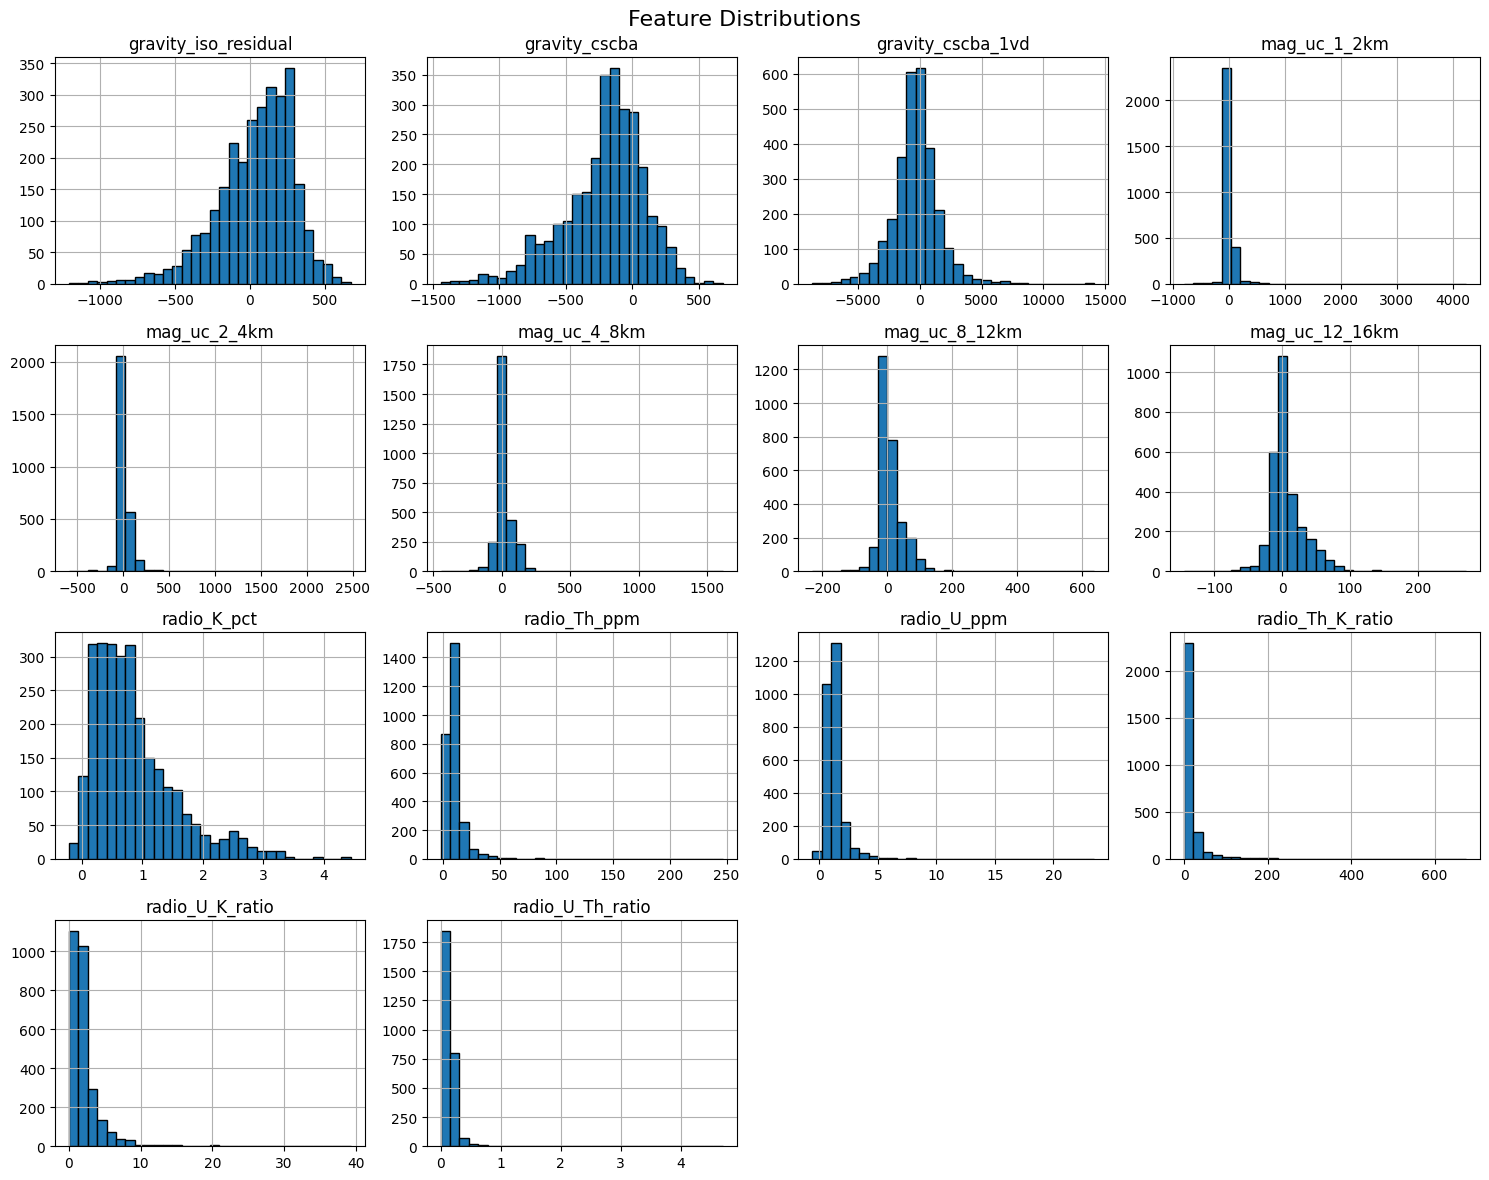

In [9]:
# Exclude non-numeric columns and non feature columns
feature_cols = df.drop(columns=['LONGITUDE', 'LATITUDE', 'LABEL', 'SOURCE']).select_dtypes(include='number').columns

# Plot feature distributions
df[feature_cols].hist(bins=30, figsize=(15, 12), edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()


The dataset is **intentionally balanced** across three source categories (~950 each), providing equal representation during model training. While the `LABEL` column is binary (porphyry vs. non-porphyry), the `SOURCE` column provides more granular insight into the nature of negative samples and may be used in **model interpretation** or **domain adaptation** analysis.

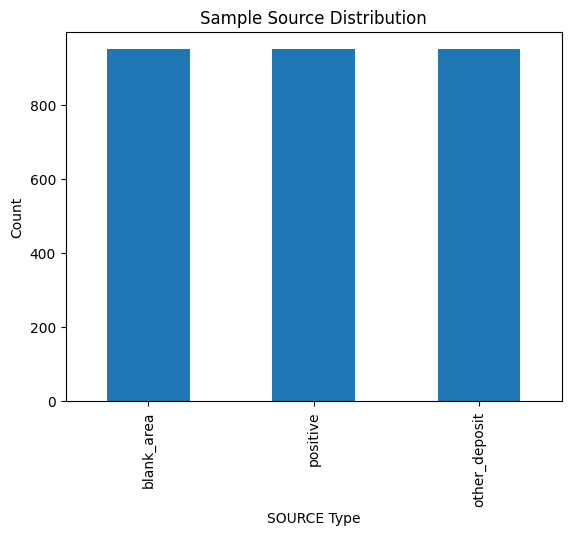

In [10]:
df['SOURCE'].value_counts().plot(kind='bar', title='Sample Source Distribution')
plt.xlabel('SOURCE Type')
plt.ylabel('Count')
plt.show()

# 3. Feature Relationships & Correlation

## 3.1. Feature Correlation Analysis

The correlation heatmap above displays the pairwise Pearson correlation coefficients between all numeric features used in the model training dataset. Values range from -1 (perfect negative correlation) to +1 (perfect positive correlation), with darker red tones indicating stronger positive relationships and blue tones representing negative ones.

- **Gravity Features**:
  - `gravity_iso_residual` and `gravity_cscba`: **very high correlation (0.88)** — both derived from gravity anomaly datasets, indicating redundant or overlapping information.
  - `gravity_cscba_1vd` has moderate correlation with `gravity_iso_residual` (0.36) and `gravity_cscba` (0.27), suggesting it captures different spatial derivatives (e.g., first vertical derivative).

- **Magnetics Features**:
  - Strong correlations exist among magnetic upward continued grids:
    - `mag_uc_1_2km` ↔ `mag_uc_2_4km`: **0.91**
    - `mag_uc_4_8km` ↔ `mag_uc_8_12km`: **0.92**
    - `mag_uc_8_12km` ↔ `mag_uc_12_16km`: **0.96**
  - These indicate depth-continuous spatial structure in magnetic anomalies and may lead to multicollinearity in models if not handled.

- **Radiometric Correlations**
  - `radio_Th_ppm`, `radio_U_ppm`, and `radio_Th_K_ratio` show **moderate correlations** with one another (e.g., Th–U: 0.69), consistent with natural elemental co-occurrence.
  - `radio_K_pct` and `radio_U_K_ratio` are **negatively correlated** (-0.42), reflecting inverse relationships in potassium-based geochemical ratios.


**Highly correlated features** may cause overfitting in linear models or inflate importance scores in tree-based models. Dimensionality reduction or feature selection (e.g., PCA, VIF filtering) may be considered. Alternatively, regularized models (e.g., Lasso, Ridge, or XGBoost) can internally mitigate these effects. Consider combining correlated magnetic features using depth-weighted averaging or principal components.

This correlation matrix confirms the presence of domain-consistent relationships among features — especially within magnetic and gravity families. Understanding these interactions supports more robust feature engineering and model interpretation downstream.


Text(0.5, 1.0, 'Feature Correlation Matrix')

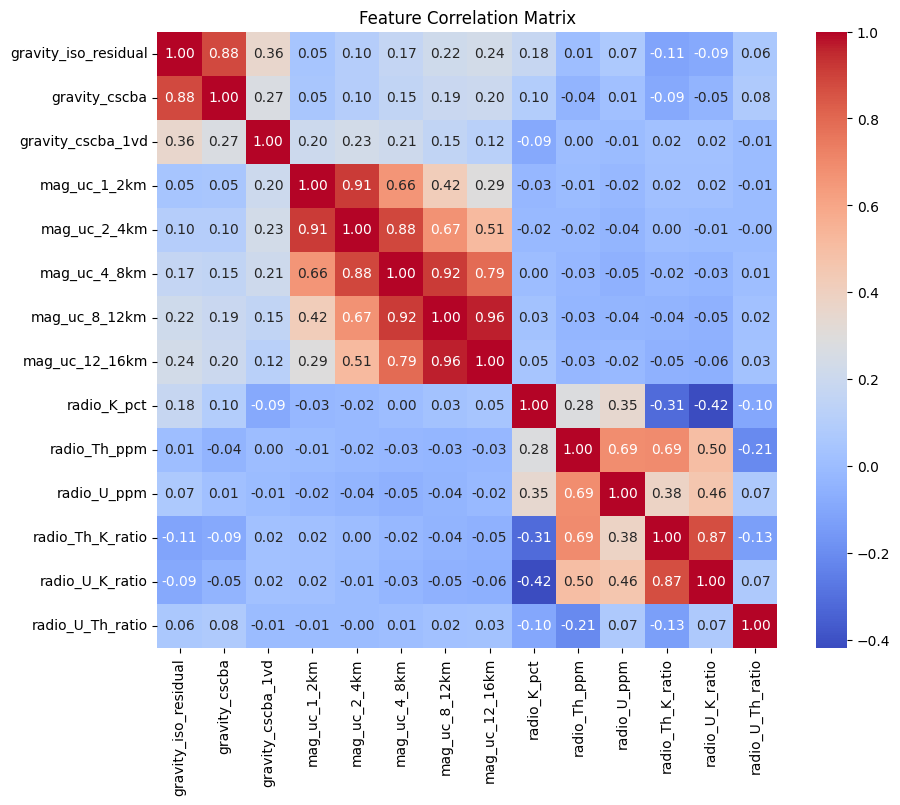

In [13]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[feature_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")

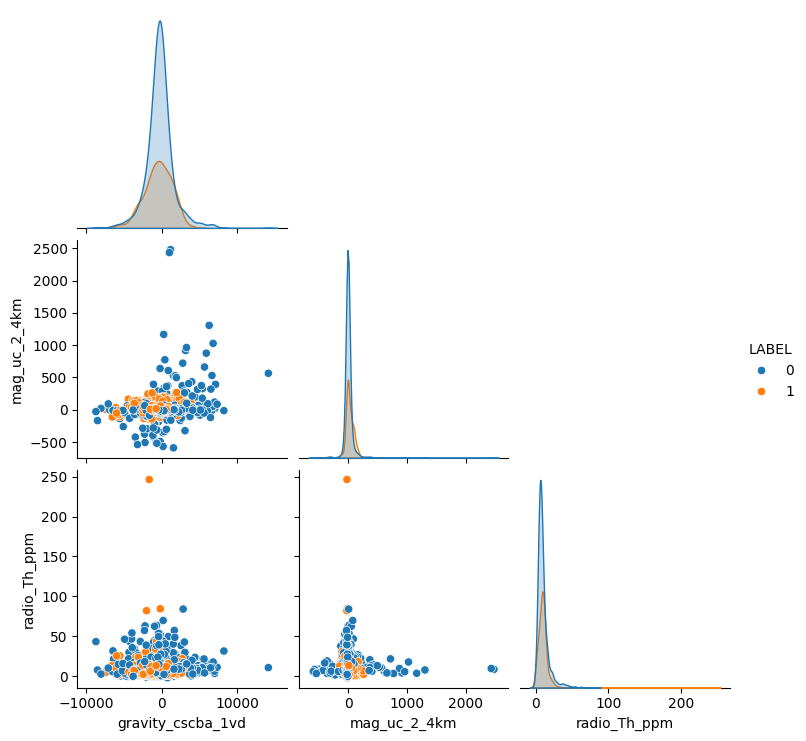

In [16]:
subset = ['gravity_cscba_1vd', 'mag_uc_2_4km', 'radio_Th_ppm', 'LABEL']
sns.pairplot(df[subset], hue='LABEL', corner=True)


## 3.2. Distribution Differences by Label (Porphyry vs. Non-Porphyry)

### Pairplot (gravity_cscba_1vd, mag_uc_2_4km, radio_Th_ppm)

The pairplot provides a visual comparison of three selected features (`gravity_cscba_1vd`, `mag_uc_2_4km`, and `radio_Th_ppm`) by `LABEL`, where:
- `LABEL = 1` represents porphyry copper samples
- `LABEL = 0` represents non-porphyry (other deposit or blank area) samples

**Key Observations:**
- `gravity_cscba_1vd` and `mag_uc_2_4km` show positive correlation in both classes, but porphyry samples tend to cluster more tightly around lower values of both.
- `radio_Th_ppm` exhibits more dispersed values among non-porphyry samples, while porphyry samples are more centered and bounded.
- Density plots on the diagonal show that porphyry samples (orange) often differ subtly in distribution tails compared to non-porphyry samples (blue).

---

### Feature-wise KDE Distributions by Label

The KDE plots below depict the distribution of **all 14 geoscience features** stratified by `LABEL`. These help visually assess how well each feature separates porphyry from non-porphyry regions.

**Notable Differentiators:**
- `gravity_iso_residual`, `gravity_cscba`, and `gravity_cscba_1vd`:  
  Show distinguishable shifts between the two classes. Porphyry samples are skewed toward higher values in some gravity features.
- `radio_K_pct` and `radio_Th_ppm`:  
  Reveal moderate label-dependent shifts, with porphyry deposits often showing higher potassium and thorium values.
- `radio_U_Th_ratio` and `radio_Th_K_ratio`:  
  Both show subtle but informative differences that could be useful for classification.
- Magnetic features (`mag_uc_*`) show relatively less separation, though deep continuation levels (`mag_uc_8_12km`, `mag_uc_12_16km`) offer better contrast.

---

### Summary

- Several gravity and radiometric features demonstrate meaningful separability between classes and can serve as strong predictors.
- KDE plots reveal distribution overlaps that suggest the model must learn **nonlinear boundaries** to separate classes effectively.
- Next steps may involve combining features, log-transforming skewed variables, and validating feature importance using model-based methods.


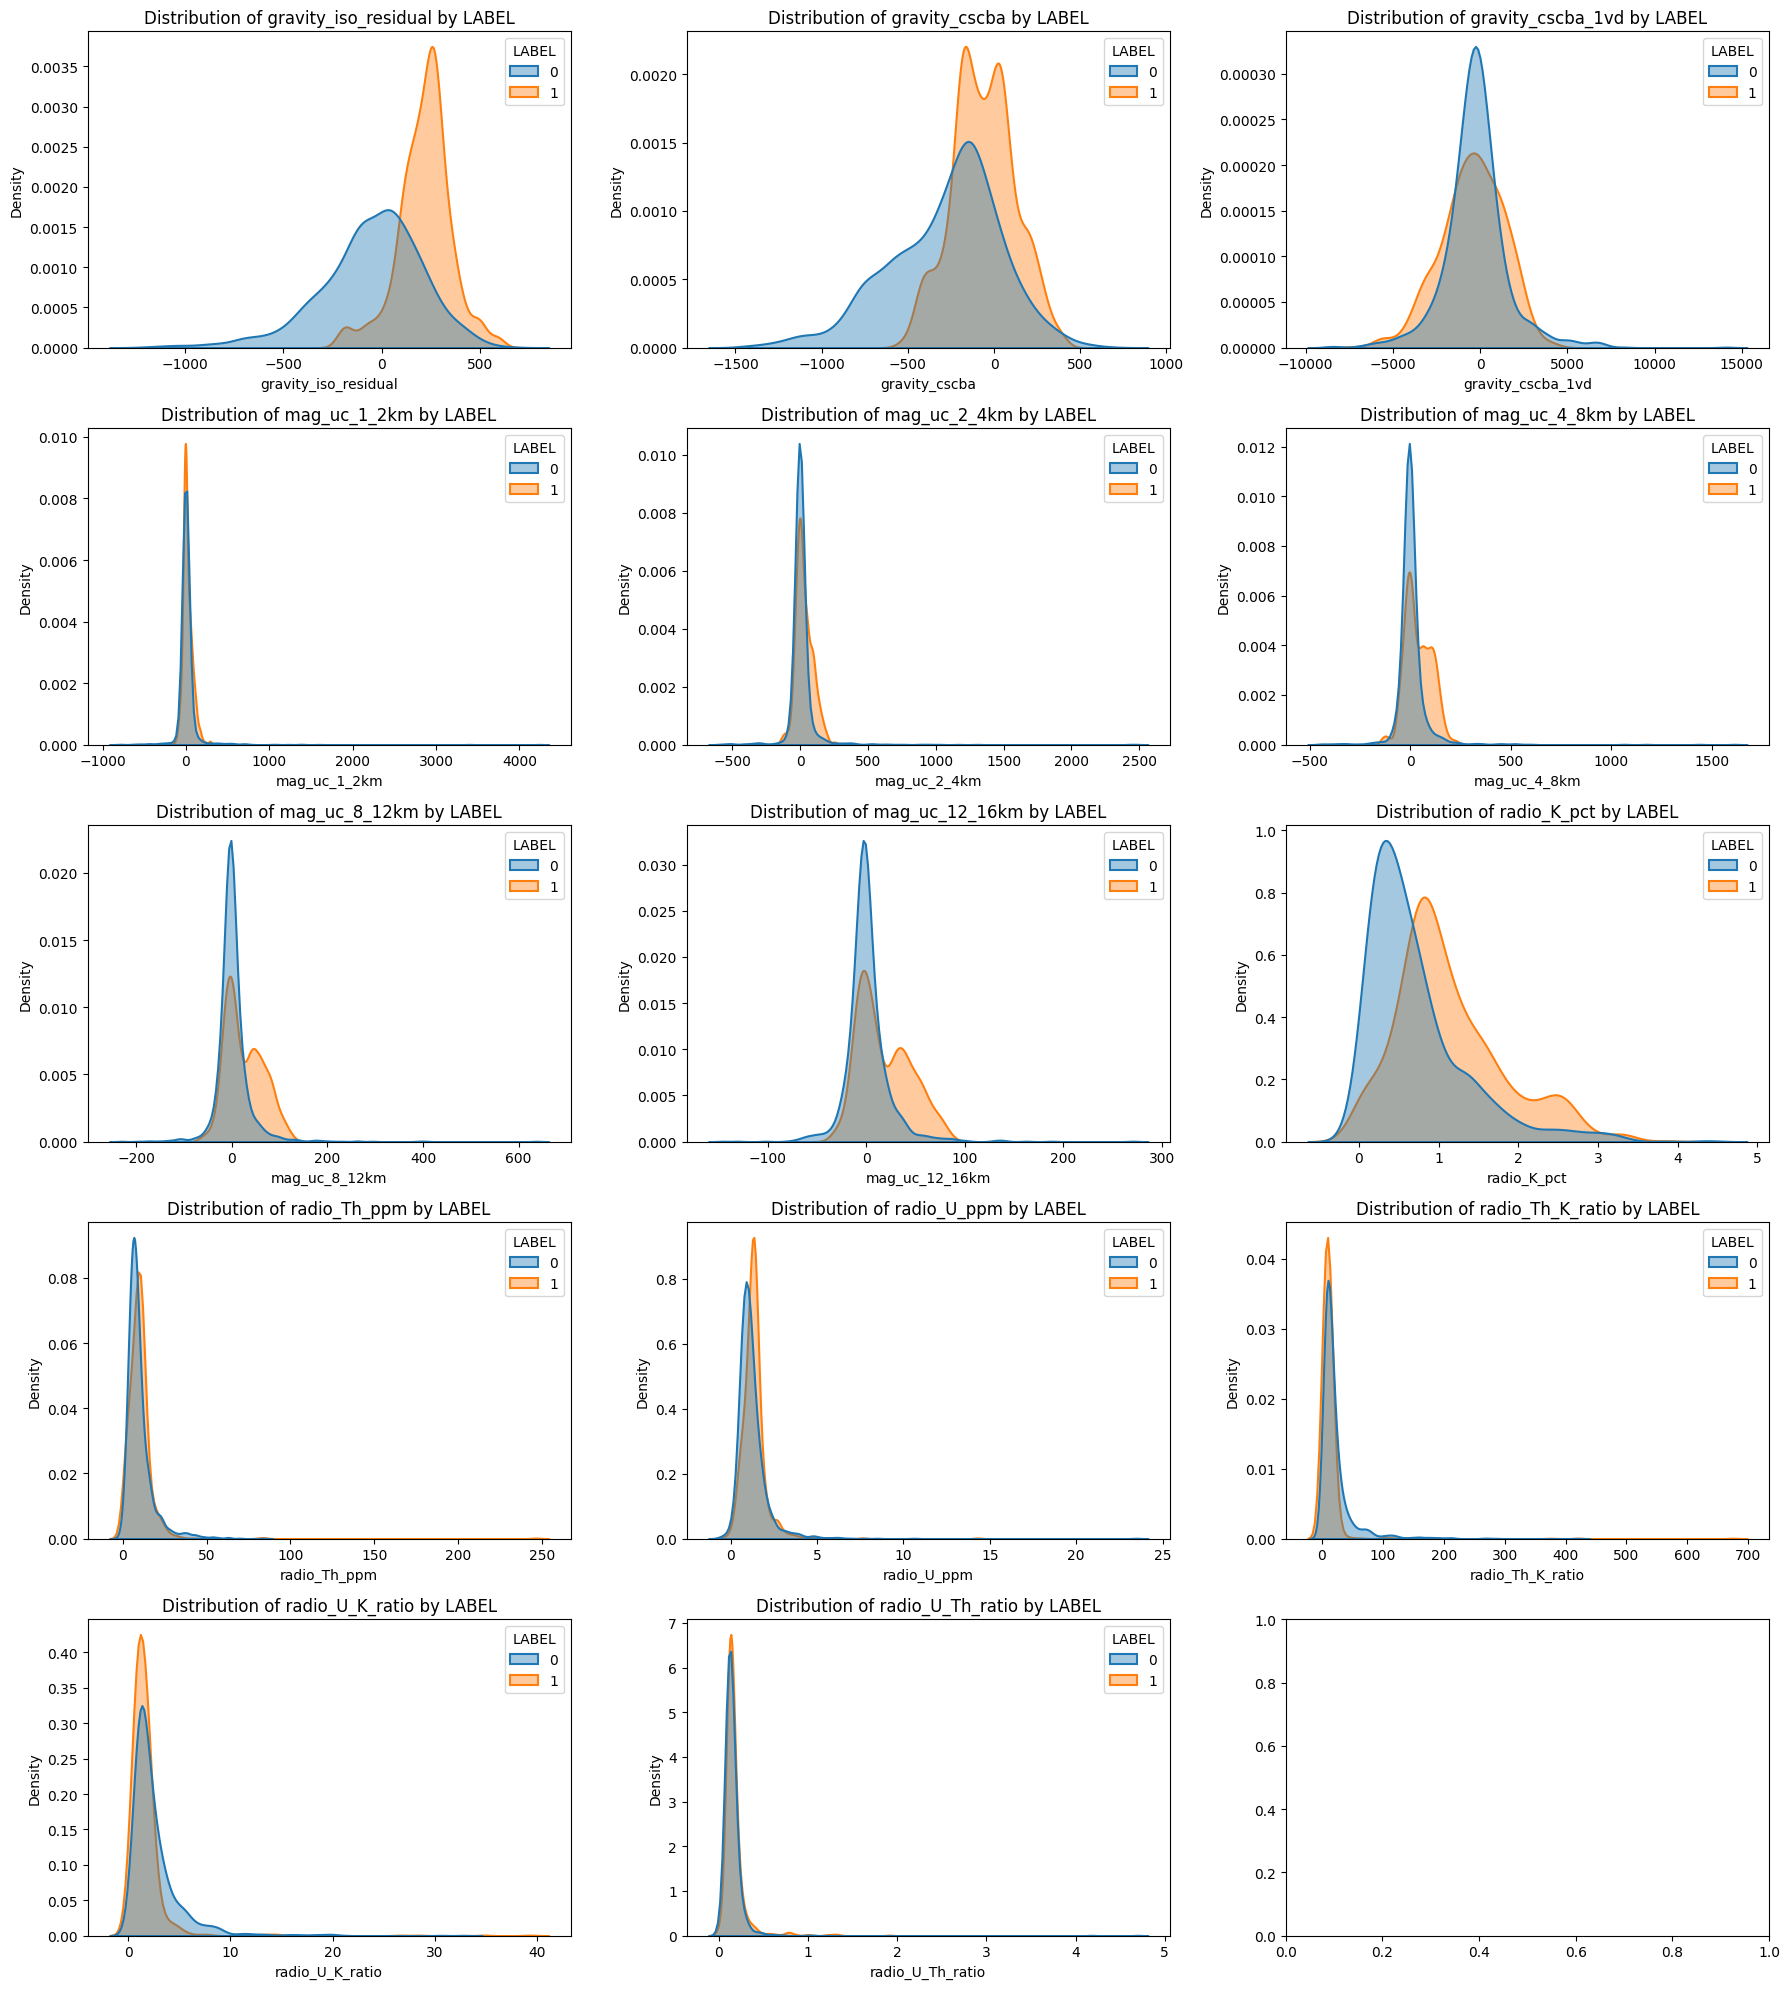

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
# Set up plots
num_features = len(feature_cols)
cols = 3
rows = math.ceil(num_features / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()
for i, feature in enumerate(feature_cols):
    sns.kdeplot(data=df, x=feature, hue='LABEL', fill=True, common_norm=False, alpha=0.4, linewidth=1.5, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by LABEL', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()


# 4. Data Quality Checks

## 4.1. Missing Values

In [23]:
missing = df.isnull().sum()
missing[missing > 0]

gravity_iso_residual     9
mag_uc_1_2km             1
mag_uc_2_4km             1
mag_uc_4_8km             1
mag_uc_8_12km            1
mag_uc_12_16km           1
radio_K_pct             91
radio_Th_ppm            91
radio_U_ppm             91
radio_Th_K_ratio        91
radio_U_K_ratio         91
radio_U_Th_ratio        91
dtype: int64

## 4.2. Duplicate Rows

In [26]:
dupes = df.duplicated().sum()
print(f"Duplicate rows: {dupes}")


Duplicate rows: 1


## 4.3. Constant or Near-Constant Feautres

In [30]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.01)
vt.fit(df.drop(columns=['LABEL', 'SOURCE']))
low_variance = df.drop(columns=['LABEL', 'SOURCE']).columns[~vt.get_support()]
print("Low variance features:", list(low_variance))


Low variance features: []


# 5. Summary of Exploratory Data Analysis (EDA)

The training dataset consists of a total of **2,850 samples**, evenly distributed across three source categories: `positive` (known porphyry copper deposits), `blank_area` (non-mineralized zones), and `other_deposit` (non-porphyry mineral sites), each containing 950 samples. The binary target variable `LABEL` is defined as `1` for porphyry copper and `0` for non-porphyry samples.

During the analysis, minor missing values (~3%) were observed in several radiometric features, including `radio_K_pct`, `radio_Th_ppm`, and `radio_U_ppm`, as well as in their derived ratio features: `radio_Th_K_ratio`, `radio_U_K_ratio`, and `radio_U_Th_ratio`.

The distribution of features reveals significant skewness. Most magnetic anomaly features (`mag_uc_*`) and radiometric features (`radio_*`) exhibit strong right-skewed distributions, with some—particularly `radio_Th_K_ratio` and `radio_U_K_ratio`—displaying extreme long tails. Kernel density plots further indicate that the distributions of several features differ notably between porphyry and non-porphyry samples.

Correlation analysis reveals strong multicollinearity within certain feature groups. For example, the gravity features `gravity_iso_residual` and `gravity_cscba` show a correlation coefficient of **0.88**. Similarly, magnetic features across different depths (e.g., `mag_uc_2_4km`, `mag_uc_4_8km`, `mag_uc_8_12km`) exhibit correlations exceeding **0.90**. There are also moderate correlations among radiometric ratios and elemental concentrations, such as between `radio_U_K_ratio` and `radio_U_ppm` (**0.46**).

A variance threshold analysis showed that all features have sufficient variability, with no features falling below the 0.01 threshold. This suggests that every feature may contribute useful information to the model. Additionally, KDE and pairplot visualizations demonstrate that porphyry samples tend to cluster within specific value ranges for some features (e.g., `gravity_cscba_1vd`, `radio_Th_ppm`, `radio_U_Th_ratio`), further confirming their potential as discriminative predictors.

---

# 6. Data Preprocessing Recommendations

**Missing Value Treatment**  
Use **median imputation** for radiometric features with missing values. Optionally, apply group-wise imputation based on `SOURCE`, or consider more advanced imputation techniques such as KNN or multivariate imputation for improved precision.

**Feature Scaling**  
- For **tree-based models** (e.g., Random Forest, XGBoost): scaling is not required.
- For **linear or distance-based models** (e.g., Logistic Regression, SVM): use `MinMaxScaler` or `RobustScaler` to normalize skewed features.

**Outlier Handling**  
Do not drop outliers, as they may contain valuable geological signals. Instead, consider applying **log-transformation** to highly skewed features, especially radiometric ratios (e.g., `radio_Th_K_ratio`, `radio_U_K_ratio`).

**Feature Selection**  
To address multicollinearity:
- Retain one representative magnetic feature (e.g., `mag_uc_2_4km`) and drop others with high correlation.
- Alternatively, apply **PCA** to reduce redundancy and compress the feature space.

**Class Balance Considerations**  
The current dataset is balanced. However, for future expansions or refined sample strategies, consider using **class weighting** or **SMOTE** to handle potential imbalance.

**Next Steps**  
- Construct and export a cleaned, preprocessed dataset (e.g., `train_data_cleaned.csv` or `.pkl`).
- Encapsulate the preprocessing pipeline into a reusable script:  
  `scripts/data_preprocessing.py` for seamless integration with backend systems.
